# 無限関係モデルによる共クラスタリングのJulia実装
---

無限関係モデル (Infinite Relational Model: IRM) によるクラスタリングを
崩壊型ギプスサンプリングでやる．

* めちゃ参考になるスライド：
    * https://www.slideshare.net/shuyo/infinite-relational-model
    * 『続・わかりやすいパターン認識』13章の式(13.26), (13.27)の致命的な数式の間違いを指摘してくれてるので目を通しておいた方がいい

In [1]:
using Distributions
using SpecialFunctions

using Plots
using DelimitedFiles
using ProgressBars

# トイデータの読み込みと可視化

In [2]:
R = readdlm("IRM_toydata_R_200402.csv", ',');
s1_gt = readdlm("IRM_toydata_s1_200402.csv", ',');
s2_gt = readdlm("IRM_toydata_s2_200402.csv", ',');

# 行・列数
K, L = size(R)

(150, 100)

In [3]:
row_idxs_gt = sort(collect(1:K), by=i->s1_gt[i]);
col_idxs_gt = sort(collect(1:L), by=i->s2_gt[i]);

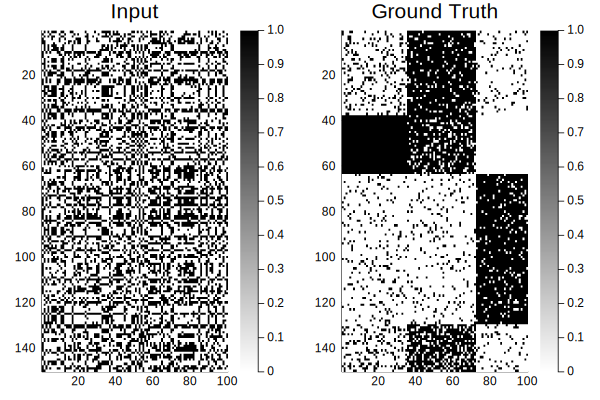

In [4]:
plot(
    heatmap(R, yflip=true, title="Input", c=ColorGradient([:white, :black])),
    heatmap(R[row_idxs_gt, col_idxs_gt], yflip=true, title="Ground Truth", c=ColorGradient([:white, :black]))
)

# モデルの初期化

IRMを表現する構造体

In [5]:
struct IRM
    c1::Int
    c2::Int
    K::Int # number of rows
    L::Int # number of cols
end

In [6]:
# モデルのハイパーパラメタ
α = 1.0;
a = 1.0;
b = 2.0;

# 初期クラスタ数
c1 = 2;
c2 = 2;

In [7]:
irm = IRM(c1, c2, K, L)

IRM(2, 2, 150, 100)

行・列の各々のオブジェクトのクラスタ割り当て$\mathbf s^1$と$\mathbf s^2$を初期化する．

In [8]:
π1 = rand(Dirichlet(α * ones(irm.c1)));
π2 = rand(Dirichlet(α * ones(irm.c2)));

s1 = rand(Categorical(π1), irm.K);
s2 = rand(Categorical(π2), irm.L);

## 崩壊型ギプスサンプリングの実装

関数`sample_s1`がテキストの式(13.26)，
関数`sample_s2`がテキストの式(13.27)の条件付き分布からのサンプリングを表す．
テキストを見てもわかる通り，ふたつの条件付き分布の違いは行か列のどっちをみているかだけなので
関数の中身もほぼ同じである．

式の中に出てくる関数$n_{(k, +)(i, j)}$とかの計算方法はNotebookの末尾に付録をつけたので参考にされたい．

In [9]:
function sample_s1(irm::IRM, R::Array{Float64, 2}, s1::Array{Int64, 1}, s2::Array{Int64, 1})
    
    for k in 1:irm.K
        state_ids = Array{Int64,1}(1:irm.c1)
        m = [count(x -> x == i, s1) for i in state_ids]
        m[s1[k]] -= 1

        # If the category s1[k] is empty, the category is removed.
        if m[s1[k]] == 0
            
            # 消されたクラスタより後ろの番号のクラスタについて，番号をつめる
            s1[s1 .> s1[k]] .-= 1

            # 消されたクラスタを削除する
            m = m[state_ids .!= s1[k]]
            
            irm = IRM(irm.c1-1, irm.c2, irm.K, irm.L)
        end

        new_mixing_coeff = [m; α]
        new_mixing_coeff = new_mixing_coeff ./ (irm.K - 1 + α)

        # Compute likelihoods
        likelihood = ones(irm.c1+1)
        for i in 1:(irm.c1)
            log_lik = 0.0
            for j in 1:(irm.c2)
                a_post_n = sum(R[s1 .== i, s2 .== j]) + a
                b_post_n = sum(1.0 .- R[s1 .== i, s2 .== j]) + b
                a_post_d = sum(R[s1 .== i, s2 .== j]) - sum(R[k, s2 .== j]) + a
                b_post_d = sum(1.0 .- R[s1 .== i, s2 .== j]) - sum(1.0 .- R[k, s2 .== j]) + b
                log_lik += lbeta(a_post_n, b_post_n) - lbeta(a_post_d, b_post_d)
            end
            likelihood[i] = exp(log_lik)
        end
        
        # For new class
        i = irm.c1+1
        log_lik = 0.0
        for j in 1:(irm.c2)
            a_post_n = sum(R[k, s2 .== j]) + a
            b_post_n = sum(1.0 .- R[k, s2 .== j]) + b
            log_lik += lbeta(a_post_n, b_post_n) - lbeta(a, b)
        end
        likelihood[i] = exp(log_lik)
        
        likelihood = likelihood ./ sum(likelihood)
        new_mixing_coeff = new_mixing_coeff .* likelihood
        new_mixing_coeff = new_mixing_coeff ./ sum(new_mixing_coeff)
        
        # Resample hidden state
        s1[k] = rand(Categorical(new_mixing_coeff))

        if s1[k] == irm.c1+1
            irm = IRM(irm.c1+1, irm.c2, irm.K, irm.L)
        else
            irm = IRM(irm.c1, irm.c2, irm.K, irm.L)
        end
    end
    
    return s1, irm
end

sample_s1 (generic function with 1 method)

In [10]:
function sample_s2(irm::IRM, R::Array{Float64, 2}, s1::Array{Int64, 1}, s2::Array{Int64, 1})
    
    for l in 1:irm.L
        state_ids = Array{Int64,1}(1:irm.c2)
        m = [count(x -> x == j, s2) for j in state_ids]
        m[s2[l]] -= 1

        # If the category s2[k] is empty, the category is removed.
        if m[s2[l]] == 0
            
            # 消されたクラスタより後ろの番号のクラスタについて，番号をつめる
            s2[s2 .> s2[l]] .-= 1

            # 消されたクラスタを削除する
            m = m[state_ids .!= s2[l]]
            
            irm = IRM(irm.c1, irm.c2-1, irm.K, irm.L)
        end

        new_mixing_coeff = [m; α]
        new_mixing_coeff = new_mixing_coeff ./ (irm.L - 1 + α)

        # Compute likelihoods
        likelihood = ones(irm.c2+1)
        for j in 1:(irm.c2)
            log_lik = 0.0
            for i in 1:(irm.c1)
                a_post_n = sum(R[s1 .== i, s2 .== j]) + a
                b_post_n = sum(1.0 .- R[s1 .== i, s2 .== j]) + b
                a_post_d = sum(R[s1 .== i, s2 .== j]) - sum(R[s1 .== i, l]) + a
                b_post_d = sum(1.0 .- R[s1 .== i, s2 .== j]) - sum(1.0 .- R[s1 .== i, l]) + b
                log_lik += lbeta(a_post_n, b_post_n) - lbeta(a_post_d, b_post_d)
            end
            likelihood[j] = exp(log_lik)
        end
        
        # For new class
        j = irm.c2+1
        log_lik = 0.0
        for i in 1:(irm.c1)
            a_post_n = sum(R[s1 .== i, l]) + a
            b_post_n = sum(1.0 .- R[s1 .== i, l]) + b
            log_lik += lbeta(a_post_n, b_post_n) - lbeta(a, b)
        end
        likelihood[j] = exp(log_lik)
        
        likelihood = likelihood ./ sum(likelihood)
        new_mixing_coeff = new_mixing_coeff .* likelihood
        new_mixing_coeff = new_mixing_coeff ./ sum(new_mixing_coeff)
        
        # Resample hidden state
        s2[l] = rand(Categorical(new_mixing_coeff))

        if s2[l] == irm.c2+1
            irm = IRM(irm.c1, irm.c2+1, irm.K, irm.L)
        else
            irm = IRM(irm.c1, irm.c2, irm.K, irm.L)
        end
    end
    
    return s2, irm
end

sample_s2 (generic function with 1 method)

崩壊型ギプスサンプリングの実行

In [11]:
for t in tqdm(1:200)
    s1, irm = sample_s1(irm, R, s1, s2);
    s2, irm = sample_s2(irm, R, s1, s2);
end

100.00%┣███████████████████████████████████████████████████████████▉┫ 200/200 00:44<00:00, 4.53 it/s]5/200 00:03<02:45, 1.18 it/s]7/200 00:04<02:02, 1.59 it/s]11/200 00:05<01:26, 2.19 it/s]20/200 00:06<00:59, 3.04 it/s]21/200 00:06<00:57, 3.12 it/s]22/200 00:07<00:56, 3.18 it/s]27/200 00:08<00:51, 3.41 it/s]29/200 00:08<00:49, 3.48 it/s]32/200 00:09<00:47, 3.59 it/s]35/200 00:09<00:45, 3.68 it/s]39/200 00:10<00:42, 3.81 it/s]41/200 00:10<00:41, 3.86 it/s]44/200 00:11<00:39, 3.95 it/s]45/200 00:11<00:39, 3.97 it/s]46/200 00:11<00:38, 4.00 it/s]50/200 00:12<00:37, 4.08 it/s]51/200 00:12<00:36, 4.10 it/s]53/200 00:13<00:35, 4.15 it/s]55/200 00:13<00:35, 4.19 it/s]56/200 00:13<00:34, 4.20 it/s]57/200 00:13<00:34, 4.21 it/s]58/200 00:13<00:34, 4.22 it/s]63/200 00:14<00:32, 4.29 it/s]64/200 00:15<00:32, 4.29 it/s]67/200 00:16<00:32, 4.13 it/s]68/200 00:16<00:32, 4.14 it/s]69/200 00:16<00:32, 4.15 it/s]71/200 00:17<00:31, 4.14 it/s]72/200 00:17<00:31, 4.15 it/s]76/200 00:18<00:30, 4.14 it/s]8

クラスタリング結果のプロット．
一見，Ground Truthと異なるようにみえる（可能性がかなり高い）が，
クラスタの順序が入れ替わってるだけなので並べ替えるとGround Truthと一致するはず．

In [12]:
row_idxs = sort(collect(1:K), by=i->s1[i]);
col_idxs = sort(collect(1:L), by=i->s2[i]);

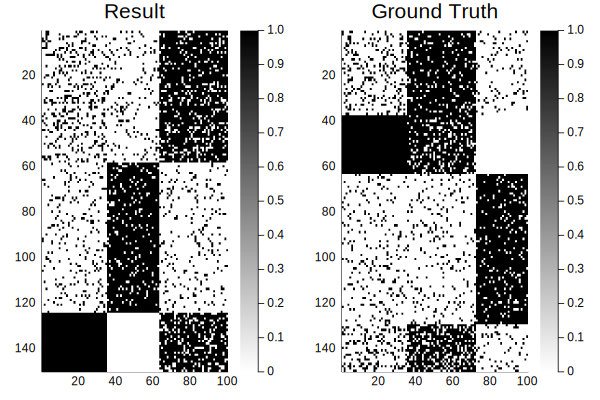

In [13]:
plot(
    heatmap(R[row_idxs, col_idxs], yflip=true, title="Result", c=ColorGradient([:white, :black])),
    heatmap(R[row_idxs_gt, col_idxs_gt], yflip=true, title="Ground Truth", c=ColorGradient([:white, :black]))
)

In [14]:
plot(
    heatmap(R, yflip=true, title="Input", c=ColorGradient([:white, :black])),
    heatmap(R[row_idxs, col_idxs], yflip=true, title="Result", c=ColorGradient([:white, :black]))
)
savefig("IRM_result_200402.png")
savefig("IRM_result_200402.pdf")

# 付録

## 関数$n_{(k, +)(i, j)}$とかの計算方法について

参考スライド（ https://www.slideshare.net/shuyo/infinite-relational-model ）の
P.17にある図のような関係行列について，
$n_{(+, +)(i, j)}$, $\bar n_{(+, +)(i, j)}$, 
$n_{(-k,+)(i,j)}$, $\bar n_{(-k,+)(i,j)}$, 
$n_{(k,+)(+,j)}$, $\bar n_{(k,+)(+,j)}$
の値の計算方法を以下に示した．
$n_{(k,+)(+,j)}$, $\bar n_{(k,+)(+,j)}$はテキスト中に記号の定義が無い上に
これらが出てくる式(13.26), (13.27)が間違ってるので注意．

In [15]:
i, j = 1, 1
k = 4

4

In [16]:
s1 = [1, 1, 1, 1, 1, 1];
s2 = [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0];

In [17]:
R = [0 0 1 0 0 1 1 0 1 1 0 0 0 0 1;
     0 1 0 0 0 1 1 1 1 1 0 0 0 0 0;
     1 0 1 0 0 1 1 1 1 1 0 0 0 0 0;
     0 0 0 0 0 1 0 0 1 1 0 0 0 1 1;
     0 0 0 0 0 1 0 1 1 1 0 0 0 0 0;
     0 1 0 1 0 0 1 1 1 1 1 0 0 0 0]

6×15 Array{Int64,2}:
 0  0  1  0  0  1  1  0  1  1  0  0  0  0  1
 0  1  0  0  0  1  1  1  1  1  0  0  0  0  0
 1  0  1  0  0  1  1  1  1  1  0  0  0  0  0
 0  0  0  0  0  1  0  0  1  1  0  0  0  1  1
 0  0  0  0  0  1  0  1  1  1  0  0  0  0  0
 0  1  0  1  0  0  1  1  1  1  1  0  0  0  0

$n_{(+, +)(i, j)}$

In [18]:
sum(R[s1 .== i, s2 .== j])

13

$\bar n_{(+, +)(i, j)}$

In [19]:
sum(1 .- R[s1 .== i, s2 .== j])

5

$n_{(k,+)(+,j)}$

In [20]:
sum(R[k, s2 .== j])

1

$\bar n_{(k,+)(+,j)}$

In [21]:
sum(1 .- R[k, s2 .== j])

2

$n_{(-k,+)(i,j)} = n_{(+,+)(i,j)} - n_{(k,+)(+,j)}$

In [22]:
sum(R[s1 .== i, s2 .== j]) - sum(R[k, s2 .== j])

12

$\bar n_{(-k,+)(i,j)} = \bar n_{(+,+)(i,j)} - \bar n_{(k,+)(+,j)}$

In [23]:
sum(1 .- R[s1 .== i, s2 .== j]) - sum(1 .- R[k, s2 .== j])

3